In [41]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1
import time

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Determine number of "events" that happen per year, and then establish your return period of interest

In [2]:
#return_period = 200 # in years
#events_per_year = 151-40

return_period = 100
events_per_year = 1

return_val_perc = 100*(1/(return_period*events_per_year))
print(return_val_perc)

1.0


In [3]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [4]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

In [5]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

# Open preindustrial control data

In [6]:
year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]

# create season strings
years_pic = numpy.arange(year_start_pic, year_end_pic+1, 1).astype(numpy.int)
half_years_pic = numpy.arange(year_start_pic+0.75, year_end_pic, 1)
#season_strings_pic = numpy.empty(years.size-1, dtype=numpy.str)

season_strings_pic = [str(years_pic[i])+'-'+str(years_pic[i+1]) for i in range(years_pic.size-1)]
member_strings_pic = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_pic=year_end_pic-year_start_pic

Steps:

1.  Import all data for PIC (at each grid point, you should have 1798 years of storm magnitude lists)
2.  At each grid point, pool all of these data together
3.  At each grid point, calculate the 99th percentile and COUNT THE NUMBER OF STORMS LARGER THAN THIS
4.  Store this number and also calculate a "events per season" number by dividing by number of years

Then when doing end-of-century stuff:

1.  Import all data for hist and RCP 8.5 for a 30-year chunk (at each grid point, you'll have 40$\times$30 years of data)
2.  Then for each grid point, calculate the number of times the 99th percentile in PIC was exceeded in hist/RCP
3.  Sum the number of exceedences, divide by (normalize by) the number of years (in this case, 30$\times$40)
4.  Take this value and divide it by the PIC value.

In [ ]:
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'
# for each grid point:
# cycle through all times, get extreme seasonal sum in each time period, store in array with length(season_strings_pic)
# once this is done, calculate the return periods of each of these
return_period_values_pic = numpy.zeros(( PRECT_nlat*PRECT_nlon, 2))
for latlon_idx in range(len(latlon_indices)):
    if latlon_idx%10==0:
        print(latlon_idx)
    filename = 'member_005_latidx_'+'{:02d}'.format(latlon_indices[latlon_idx][0])+'_lonidx_'+'{:02d}'.format(latlon_indices[latlon_idx][1])+'_years_'+'{:04d}'.format(year_start_pic)+'-'+'{:04d}'.format(year_end_pic)+'_threshold_'+str(threshold)+'mmday_'+region+'.npy'
    dict_pic = numpy.load(working_dir + filename).item()
    #print(dict_pic['402-403'].keys())
    seasonal_events_list = [dict_pic[i]['seasonal_total'] for i in dict_pic.keys()]
    return_period_values_pic[latlon_idx,0] = numpy.percentile(seasonal_events_list, return_val_perc)#, interpolation='nearest')
    return_period_values_pic[latlon_idx,1] = numpy.sum(seasonal_events_list<return_period_values_pic[latlon_idx,0])

In [7]:
return_period_values_pic_df = pandas.read_csv('csv_files/return_period_values_pic_df.csv')
return_period_values_pic = return_period_values_pic_df.values[:,1:]

# Open historical and RCP8.5 data

In [8]:
year_start = 2070
year_end = 2100

year_start_list = [1920,1950,1980,2010,2040,2070]
year_end_list = [1950,1980,2010,2040,2070,2100]

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)

season_strings_hist_rcp = [str(years[i])+'-'+str(years[i+1]) for i in range(years.size-1)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [9]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

# Load data as csv file

In [10]:
return_period_values_hist_rcp_df = pandas.read_csv('csv_files/return_period_values_hist_rcp_dataframe_2070-2100.csv')
return_period_values_hist_rcp = return_period_values_hist_rcp_df.values[:,1:]

In [11]:
pic_counts = return_period_values_pic[:,1]
hist_rcp_counts = return_period_values_hist_rcp[:,2]

# Plot return values for PIC

In [12]:
return_values_pic_2d = return_period_values_pic[:,0].reshape(PRECT_nlat, PRECT_nlon)

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


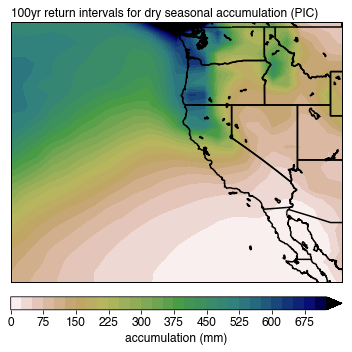

In [13]:
fontsize=12
contour_levels = numpy.arange(0,750,25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_pic_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='100yr return intervals for dry seasonal accumulation (PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('100yr_return_values_dry_seasonal_accumulation_PIC.pdf', transparent=True, bbox_inches='tight')

In [14]:
return_values_hist_rcp_2d = return_period_values_hist_rcp[:,0].reshape(PRECT_nlat, PRECT_nlon)

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


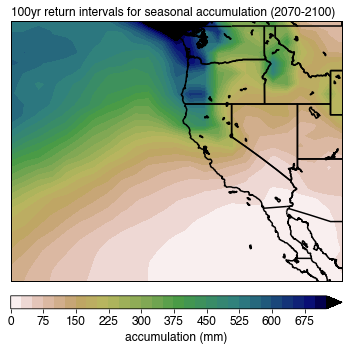

In [15]:
fontsize=12
contour_levels = numpy.arange(0,750,25)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, return_values_hist_rcp_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('accumulation (mm)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)

ax.text(s='100yr return intervals for seasonal accumulation (2070-2100)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('100yr_return_values_seasonal_accumulation_2070-2100.pdf', transparent=True, bbox_inches='tight')

# Plot relative change in PIC 100yr return interval exceedances

In [16]:
count_ratio = (hist_rcp_counts/(30*40))/(pic_counts/1798)
count_ratio_2d = count_ratio.reshape((PRECT_nlat, PRECT_nlon))

In [17]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [18]:
# make color map
minval=0.0 # 
maxval=0.85 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:350

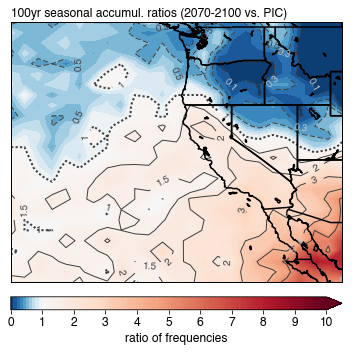

In [38]:
fontsize=12
contour_levels = numpy.arange(0,10.01,0.1)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, count_ratio_2d, \
                      #cmap='inferno', \
                      cmap='RdBu_r', \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, count_ratio_2d, \
                         levels=[0.1,0.3,0.5,1.,1.5,2,3,4,5.,10.,15.,20.,25.,30.], \
                         colors='0.25', \
                         linewidths=[1]*3+[2]+[1]*10, \
                         linestyles=['--']*3+[':']+['-']*10, \
                         )

new_levels = []
for i in contour_plot.levels:
    if i in [0.1,0.2,0.3,0.4,0.5,1.5]:
        new_levels.append('{:.1f}'.format(i))
    else:
        new_levels.append('{:.0f}'.format(i))
contour_plot.levels = new_levels
mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.75']*2+['0.25']*5+['0.75']*5)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('ratio of frequencies', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10])

ax.text(s='100yr seasonal accumul. ratios (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('100yr_return_values_seasonal_accumulation_RATIOS.pdf', transparent=True, bbox_inches='tight')

# Now plot the fraction of the magnitudes of the Nth percentile

In [22]:
return_period_value_ratios_2d = return_values_hist_rcp_2d/return_values_pic_2d

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:350

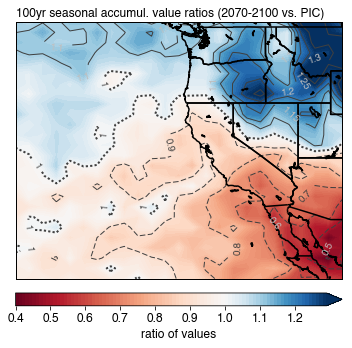

In [46]:
fontsize=12
contour_levels = numpy.arange(0.4,1.3,0.01)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, return_period_value_ratios_2d, \
                      #cmap='inferno', \
                      cmap='RdBu', \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, return_period_value_ratios_2d, \
                         levels=[0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.15,1.2,1.25,1.3,1.4,1.5], \
                         colors='0.25', \
                         linewidths=[1]*6+[2]+[1]*7, \
                         linestyles=['--']*6+[':']+['-']*7, \
                         )

new_levels = []
for i in contour_plot.levels:
    if i in [1]:
        new_levels.append('{:.0f}'.format(i))
    elif i in [1.15,1.25]:
        new_levels.append('{:.2f}'.format(i))
    else:
        new_levels.append('{:.1f}'.format(i))
contour_plot.levels = new_levels
mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.75']*3+['0.25']*4+['0.75']*7)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('ratio of values', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
cbar.set_ticks(numpy.arange(0.4,1.31,0.1))

ax.text(s='100yr seasonal accumul. value ratios (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('100yr_return_values_seasonal_accumulation_RATIOS_of_magnitudes.pdf', transparent=True, bbox_inches='tight')

# Saving as NetCDF4 (make sure to import time)

In [45]:
# save hist clim
filename = '100yr_dry_accumulations.nc'

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lon_dim = ncfile.createDimension('lon', PRECT_lon.size)

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lat_var[:] = PRECT_lat
lon_var[:] = PRECT_lon
lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

return_values_pic = ncfile.createVariable('return_values_pic', 'f4', ('lat','lon'))
return_values_pic[:] = return_values_pic_2d
return_values_pic.units = 'mm'
return_values_pic.description = '100yr seasonal LOW accumulation return values calculated during PIC runs'

return_values_eoc = ncfile.createVariable('return_values_eoc', 'f4', ('lat','lon'))
return_values_eoc[:] = return_values_hist_rcp_2d
return_values_eoc.units = 'mm'
return_values_eoc.description = '100yr seasonal LOW accumulation return values calculated during RCP8.5 runs (2070-2100)'

ratios_of_values = ncfile.createVariable('ratios_of_values', 'f4', ('lat','lon'))
ratios_of_values[:] = return_period_value_ratios_2d
ratios_of_values.units = 'unitless'
ratios_of_values.description = 'Ratios of LOW 100yr return values (2070-2100 vs. PIC)'

ratios_of_frequencies = ncfile.createVariable('ratios_of_frequencies', 'f4', ('lat','lon'))
ratios_of_frequencies[:] = count_ratio_2d
ratios_of_frequencies.units = 'unitless'
ratios_of_frequencies.description = 'Ratios of LOW 100yr return value exceedance frequencies (2070-2100 vs. PIC)'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")

100yr_dry_accumulations.nc saved
